# Load packages

In [159]:
import kfp
from kfp import components
from kfp.components import load_component_from_file, load_component_from_url
from kfp import dsl
from kfp import compiler

# Enter your gateway loadbalancer and the token from the cookie
[Use this extension on chrome to get token]( https://chrome.google.com/webstore/detail/editthiscookie/fngmhnnpilhplaeedifhccceomclgfbg?hl=en)

![image.png](./image.png)

In [160]:
#Update values for the load balancer and auth session
URL='<your-load-balancer-url>'
AUTH="authservice_session=<Key>"
namespace="admin"

In [161]:
client = kfp.Client(host=URL+"/pipeline", cookies=AUTH)
experiments = client.list_experiments(namespace=namespace)
my_experiment = experiments.experiments[0]
my_experiment

{'created_at': datetime.datetime(2021, 4, 22, 11, 1, 18, tzinfo=tzlocal()),
 'description': None,
 'id': '1ff11bc4-a6b3-4dd1-8874-2c8cfccca04c',
 'name': 'Default',
 'resource_references': [{'key': {'id': 'admin', 'type': 'NAMESPACE'},
                          'name': None,
                          'relationship': 'OWNER'}],
 'storage_state': 'STORAGESTATE_AVAILABLE'}

### Using dsl for model archiver and torchserve integration
#### Init container is used for mar file generation

In [151]:
VOLUME_NAME = "pvcmaad"
DEPLOY="bert-testt"
MODEL="bert"

In [152]:
bert_data_prep_op = components.load_component_from_file(
    "./pytorch/data_prep/component.yaml"
)

bert_train_op = components.load_component_from_file(
    "./pytorch/train/component.yaml"
)

mar_op = load_component_from_file("./model_archive/component.yaml")
deploy_op = load_component_from_file("./deploy/component.yaml")

@dsl.pipeline(name="Training pipeline", description="Sample training job test")
def pytorch_bert():


    vop = dsl.VolumeOp(
        name=VOLUME_NAME,
        resource_name=VOLUME_NAME,
        modes=dsl.VOLUME_MODE_RWO,
        size="20Gi"
    )

    @dsl.component
    def download(url: str, output_path:str):
        return dsl.ContainerOp(
            name='Download',
            image='busybox:latest',
            command=["sh", "-c"],
            arguments=["mkdir -p %s; wget %s -P %s" % (output_path, url, output_path)],
        )

    @dsl.component
    def copy_contents(input_dir: str, output_dir:str):
        return dsl.ContainerOp(
            name='Copy',
            image='busybox:latest',
            command=["cp", "-R", "%s/." % input_dir, "%s" % output_dir],            
        )

    @dsl.component
    def mkdir(input_dir: str):
        return dsl.ContainerOp(
            name='mkdir',
            image='busybox:latest',
            command=["mkdir", "-p", "%s" % input_dir],            
        )

    @dsl.component
    def ls(input_dir: str):
        return dsl.ContainerOp(
            name='list',
            image='busybox:latest',
            command=["ls", "-R", "%s" % input_dir]
        )

    prep_output = bert_data_prep_op(
        input_data =
            [{"dataset_url":"https://kubeflow-dataset.s3.us-east-2.amazonaws.com/ag_news_csv.tar.gz"}],
        container_entrypoint = [
            "python",
            "/pvc/input/bert_pre_process.py",
        ],
        output_data = ["/pvc/output/processing"],
        source_code = ["https://kubeflow-dataset.s3.us-east-2.amazonaws.com/bert_pre_process.py"],
        source_code_path = ["/pvc/input"]
    ).add_pvolumes({"/pvc":vop.volume})

    train_output = bert_train_op(
        input_data = ["/pvc/output/processing"],
        container_entrypoint = [
            "python",
            "/pvc/input/bert_train.py",
        ],
        output_data = ["/pvc/output/train/models"],
        input_parameters = [{"tensorboard_root": "/pvc/output/train/tensorboard", 
        "max_epochs": 1, "num_samples": 1000, "batch_size": 4, "num_workers": 1, "learning_rate": 0.001, 
        "accelerator": None}],
        source_code = ["https://kubeflow-dataset.s3.us-east-2.amazonaws.com/bert_datamodule.py", "https://kubeflow-dataset.s3.us-east-2.amazonaws.com/bert_train.py"],
        source_code_path = ["/pvc/input"]
    ).add_pvolumes({"/pvc":vop.volume}).after(prep_output)

    list_input = ls("/pvc/output").add_pvolumes({"/pvc":vop.volume}).after(train_output)

    properties = download(url='https://kubeflow-dataset.s3.us-east-2.amazonaws.com/model_archive/bert/properties.json', output_path="/pv/input").add_pvolumes({"/pv":vop.volume}).after(vop)
    requirements = download(url='https://kubeflow-dataset.s3.us-east-2.amazonaws.com/model_archive/bert/requirements.txt', output_path="/pv/input").add_pvolumes({"/pv":vop.volume}).after(vop)
    extrafile = download(url='https://kubeflow-dataset.s3.us-east-2.amazonaws.com/model_archive/bert/index_to_name.json', output_path="/pv/input").add_pvolumes({"/pv":vop.volume}).after(vop)
    extrafile = download(url='https://kubeflow-dataset.s3.us-east-2.amazonaws.com/model_archive/bert/wrapper.py', output_path="/pv/input").add_pvolumes({"/pv":vop.volume}).after(vop)
    vocabfile = download(url='https://kubeflow-dataset.s3.us-east-2.amazonaws.com/model_archive/bert/bert-base-uncased-vocab.txt', output_path="/pv/input").add_pvolumes({"/pv":vop.volume}).after(vop)
    handlerfile = download(url='https://kubeflow-dataset.s3.us-east-2.amazonaws.com/model_archive/bert/bert_handler.py', output_path="/pv/input").add_pvolumes({"/pv":vop.volume}).after(vop)

    copy_files = copy_contents(input_dir="/pvc/output/train/models", output_dir="/pvc/input").add_pvolumes({"/pvc":vop.volume}).after(train_output)
    list_input = ls("/pvc/input").add_pvolumes({"/pvc":vop.volume}).after(copy_files)

    mar_task = mar_op(
        input_dir="/pvc/input",
        output_dir="/pvc/output",
        handlerfile="image_classifier").add_pvolumes({"/pvc":vop.volume}).after(list_input)

    list_output = ls("/pvc/output").add_pvolumes({"/pvc":vop.volume}).after(mar_task)

    model_uri= "pvc://{{workflow.name}}-"+VOLUME_NAME+"/output"
    isvc_yaml = '''
    apiVersion: "serving.kubeflow.org/v1beta1"
    kind: "InferenceService"
    metadata:
      name: {}
      namespace: {}
    spec:
      predictor:
        pytorch:
          storageUri: {}
          resources:
            limits:
              memory: 4Gi   
    '''.format(DEPLOY, namespace, model_uri)
    deploy_task = deploy_op(
        action='apply',
        inferenceservice_yaml=isvc_yaml
    ).add_pvolumes({"/pvc":vop.volume}).after(list_output)

In [153]:
# Compile pipeline
compiler.Compiler().compile(pytorch_bert, 'pytorch.tar.gz', type_check=True)

In [154]:
# Execute pipeline
run = client.run_pipeline(my_experiment.id, 'pytorch-bert', 'pytorch.tar.gz')

### Wait for inference service below to go to `READY True` state.

In [155]:
!kubectl get isvc $DEPLOY

Error from server (NotFound): inferenceservices.serving.kubeflow.org "bert-testt" not found


# Inference

In [12]:
# S_HOSTNAME=!kubectl get isvc $DEPLOY  -o jsonpath='{.items[0].status.url}' | cut -d "/" -f 3
# SERVICE_HOSTNAME=S_HOSTNAME[0]
# SERVICE_HOSTNAME

'bert-agnc.admin.example.com'

# Prediction

In [18]:
!cat sample.text

{
  "instances": [
    {
      "data": "Bloomberg has reported the economy"
    }
  ]
}

In [162]:
!curl -v -H "Host: bert-testt.admin.example.com" -H "Cookie: $AUTH" "$URL/v1/models/bert:predict" -d @./sample.text

*   Trying 34.212.253.76...
* TCP_NODELAY set
* Connected to a6cbacea2ae994ca4b8773a7efb86526-960991965.us-west-2.elb.amazonaws.com (34.212.253.76) port 80 (#0)
> POST /v1/models/bert:predict HTTP/1.1
> Host: bert-testt.admin.example.com
> User-Agent: curl/7.58.0
> Accept: */*
> Cookie: authservice_session=MTYxOTA5MjMwM3xOd3dBTkRKQlNsaFNWRmMyU1RaWFNUUlFVVXhCV0ZKQlYxTkNRMHBJUWxwTFQxcEVXbFJPVDBsV1JWUkpSRmMzVFZwV1N6UktWRUU9fP5T5N7_YeUMuxJJc3MkKctnvKBzFTQNLqOzms8E109d
> Content-Length: 81
> Content-Type: application/x-www-form-urlencoded
> 
* upload completely sent off: 81 out of 81 bytes
< HTTP/1.1 200 OK
< content-length: 33
< content-type: application/json; charset=UTF-8
< date: Fri, 23 Apr 2021 09:07:02 GMT
< server: istio-envoy
< x-envoy-upstream-service-time: 5244
< 
* Connection #0 to host a6cbacea2ae994ca4b8773a7efb86526-960991965.us-west-2.elb.amazonaws.com left intact
{"predictions": ["\"Sci/Tech\""]}

##### Explain request with Captum Insights Image

In [167]:
!curl -v -H "Host: bert-testt.admin.example.com" -H "Cookie: $AUTH" "$URL/v1/models/bert:explain" -d @./sample.text > output.json

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0*   Trying 34.212.253.76...
* TCP_NODELAY set
* Connected to a6cbacea2ae994ca4b8773a7efb86526-960991965.us-west-2.elb.amazonaws.com (34.212.253.76) port 80 (#0)
> POST /v1/models/bert:explain HTTP/1.1
> Host: bert-testt.admin.example.com
> User-Agent: curl/7.58.0
> Accept: */*
> Cookie: authservice_session=MTYxOTA5MjMwM3xOd3dBTkRKQlNsaFNWRmMyU1RaWFNUUlFVVXhCV0ZKQlYxTkNRMHBJUWxwTFQxcEVXbFJPVDBsV1JWUkpSRmMzVFZwV1N6UktWRUU9fP5T5N7_YeUMuxJJc3MkKctnvKBzFTQNLqOzms8E109d
> Content-Length: 81
> Content-Type: application/x-www-form-urlencoded
> 
} [81 bytes data]
* upload completely sent off: 81 out of 81 bytes
100    81    0     0  100    81      0      3  0:00:27  0:00:25  0:00:02     0< HTTP/1.1 200 OK
< content-length: 296
< content-type: application/json; ch

##### Lets read the output json created by the above step for visulization purpose

In [20]:
import json
explanations_json = json.loads(open("./output.json", "r").read())

In [21]:
explanations_json

{'explanations': [{'words': ['[CLS]',
    'bloomberg',
    'has',
    'reported',
    'the',
    'economy',
    '[SEP]'],
   'importances': [0.41797560190204697,
    0.1503530580737833,
    -0.1913129613875043,
    0.005988620683665899,
    -0.16190090540645485,
    0.5718536465796493,
    -0.642514859821982],
   'delta': 0.10401920533973452}]}

In [33]:
import torch
attributions = explanations_json["explanations"][0]['importances']
tokens = explanations_json["explanations"][0]['words']
delta = explanations_json["explanations"][0]['delta']

attributions = torch.tensor(attributions)
pred_prob = 0.75
pred_class = 3
true_class = 2
attr_class =1

In [36]:
from captum.attr import visualization
vis_data_records =[]
vis_data_records.append(visualization.VisualizationDataRecord(
                            attributions,
                            pred_prob,
                            pred_class,
                            true_class,
                            attr_class,
                            attributions.sum(),       
                            tokens,
                            delta))


In [37]:
visualization.visualize_text(vis_data_records)

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
2,3 (0.75),1,0.15,[CLS] bloomberg has reported the economy [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
2,3 (0.75),1,0.15,[CLS] bloomberg has reported the economy [SEP]


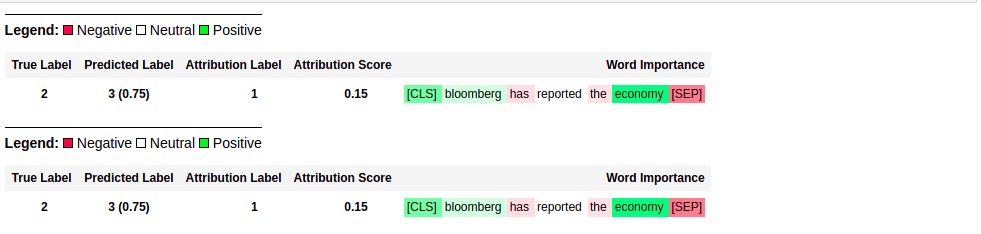

In [39]:
import IPython.display
IPython.display.Image(filename="Bert_KFS_Captum_Insights.png")
